In [1]:
import yaml
import functools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from evml.keras.models import DenseNormalGamma, EvidentialRegressorDNN
from evml.keras.losses import EvidentialRegressionLoss

2023-02-07 09:37:35.292057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 09:37:35.422778: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-07 09:37:36.091239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cudnn/8.0.4.30/cuda/11.0.3/lib64:/glade/u/apps/dav/opt/cuda/11.0.

In [2]:
#### Helper functions ####

def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)
    
    if train:
        sigma = 3 * np.ones_like(x) 
        y = x**3 + np.random.normal(0, sigma).astype(np.float32)
        noise1 = np.random.normal(0, 10, len(x))
        scale1 = np.linspace(0, 1, int(len(x) / 2))
        scale2 = np.linspace(1, 0, int(len(x) / 2))
        scale = np.concatenate([scale1, scale2])
        noise = noise1 * scale 
        y = (y.squeeze() + noise).reshape(-1, 1)
    
    else:
        sigma = np.zeros_like(x)
        y = (x**3 + np.random.normal(0, sigma).astype(np.float32))
    return x, y

# Create some training and testing data
x_train, y_train = my_data(-4, 4, 10000)
x_test, y_test = my_data(-7, 7, 10000, train=False)

# Scale data
input_scaler = MinMaxScaler((0.1, 1.1))
output_scaler = MinMaxScaler((0.1, 1.1))
x_train_scaled = input_scaler.fit_transform(x_train)
y_train_scaled = output_scaler.fit_transform(y_train)
x_test_scaled = input_scaler.transform(x_test)
y_test_scaled = output_scaler.transform(y_test)

In [3]:
with open("../config/regression.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [4]:
# Define our model with an evidential output
model = EvidentialRegressorDNN(**conf["model"])
model.fit(x_train, y_train)
# model.fit(x_train_scaled, y_train_scaled, batch_size=100, epochs=500, verbose=0)

2023-02-07 09:37:37.627599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-07 09:37:37.627643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc46): /proc/driver/nvidia/version does not exist
2023-02-07 09:37:37.630592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model_loaded = load_model('./test_model/model.h5',
                          custom_objects={'DenseNormalGamma': DenseNormalGamma,
                                          'loss': EvidentialRegressionLoss(conf['model']['evidential_coef'])},
                          # compile=False)

In [9]:
# Predict and plot using the trained model
# y_pred = model.predict(x_test_scaled, output_scaler)
y_pred = model.predict(x_test)

10/10 [==============================] - 0s 1ms/step


/glade/work/ggantos/evidential/evml/keras/models.py:161: RuntimeWarning: divide by zero encountered in divide
  aleatoric = np.sqrt((beta / (alpha - 1)) * self.training_var)
/glade/work/ggantos/evidential/evml/keras/models.py:162: RuntimeWarning: divide by zero encountered in divide
  epistemic = np.sqrt((beta / (v * (alpha - 1))) * self.training_var)


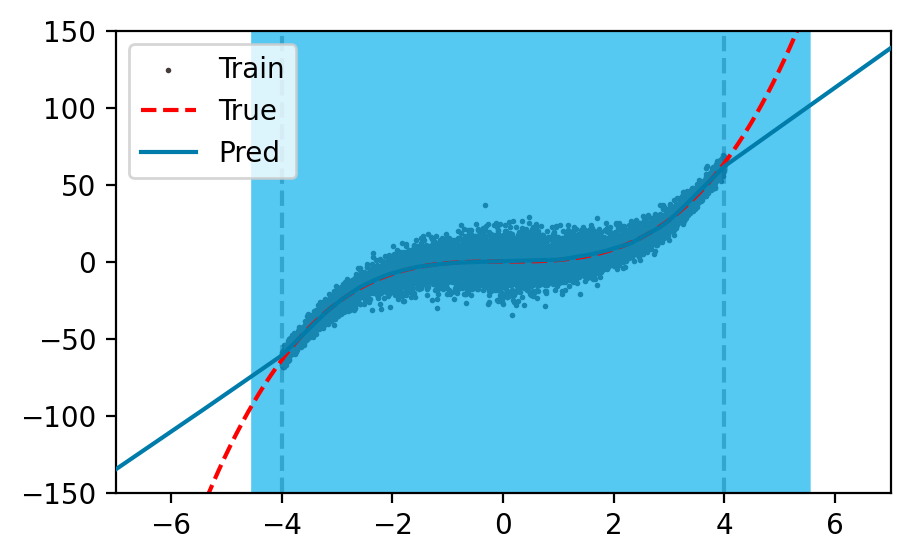

In [10]:
def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    # mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    # mu = mu[:, 0]
    # epi = np.sqrt(beta / (v * (alpha - 1)))
    # epi = np.minimum(epi, 1e3)[:, 0]  # for visualization
    # ale = np.sqrt(beta / (alpha - 1))[:, 0]
    
    mu, ale, epi = tf.split(y_pred, 3, axis=-1)
    mu = mu[:, 0]
    ale = ale[:, 0]
    epi = epi[:, 0]
    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.arange(1, n_stds):
        plt.fill_between(
            x_test, (mu - k * epi), (mu + k * epi),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    # plt.gca().set_ylim(-4, 4)

    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()
    return mu, ale, epi

mu, ale, epi = plot_predictions(x_train, y_train, x_test, y_test, y_pred)

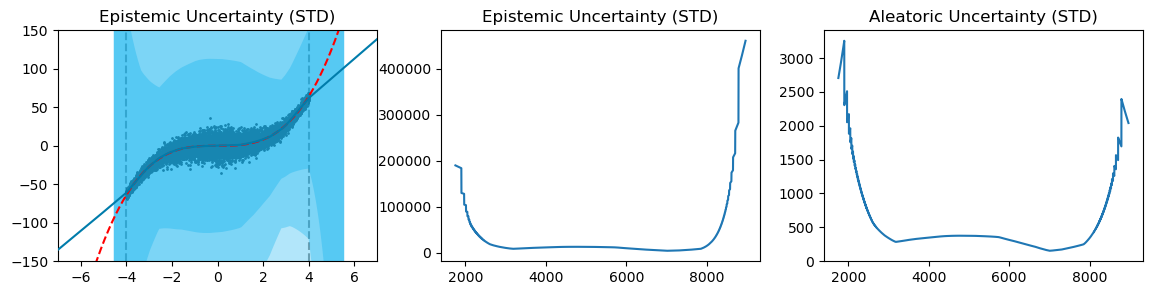

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
axes[1].plot(epi)
axes[1].set_title('Epistemic Uncertainty (STD)')
axes[2].plot(ale)
axes[2].set_title('Aleatoric Uncertainty (STD)')
axes[0].scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
axes[0].plot(x_test, y_test, 'r--', zorder=2, label="True")
axes[0].plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
axes[0].plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
axes[0].plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

epi_std = np.sqrt(epi)
for k in np.arange(1, 4):
    axes[0].fill_between(
        x_test[:, 0], (mu - k * epi_std), (mu + k * epi_std),
        alpha=0.3,
        edgecolor=None,
        facecolor='#00aeef',
        linewidth=0,
        zorder=1,
        label="Unc." if k == 0 else None)
axes[0].set_title('Epistemic Uncertainty (STD)')
axes[0].set_ylim(-150, 150)
axes[0].set_xlim(-7, 7)
plt.show()
# plt.savefig('/glade/scratch/cbecker/synthetic_uncertainty.png', dpi=200, bbox_inches='tight')

In [ ]:
y_pred = model.predict(x_test_scaled)
mu = output_scaler.inverse_transform(y_pred[:, 0].reshape(-1, 1))
v = input_scaler.inverse_transform(y_pred[:, 1].reshape(-1, 1))
alpha = y_pred[:, 2]
beta = y_pred[:, 3]
ale = np.sqrt(beta / (alpha - 1))
epi = ((beta / (v.squeeze() *(alpha - 1))))

In [ ]:
y_pred = output_scaler.inverse_transform(model.predict(x_test_scaled))
mu = y_pred[:, 0]
v = y_pred[:, 1]
alpha = y_pred[:, 2]
beta = y_pred[:, 3]
ale = np.sqrt(beta / (alpha - 1))
epi = ((beta / (v.squeeze() *(alpha - 1))))

In [ ]:
plt.plot(v)

In [ ]:
plt.plot(ale)
# plt.plot(epi)

In [ ]:
plt.plot(mu)

In [ ]:
# plt.plot(ale / v)
plt.plot(ale)
plt.plot(epi)

In [ ]:
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1) #np.var(y_train_scaled)

ale = np.sqrt((beta / (alpha - 1)) * np.var(y_train))
epi = np.sqrt((beta / (v * (alpha - 1))))

plt.plot(ale)
plt.plot(epi)

In [ ]:
plt.plot(ale-epi)

In [ ]:
d = my_data(-4, 4, 1000)[1]
n = np.random.normal(0, 5).astype(np.float32)
plt.plot(d+n)

In [ ]:
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
ale = np.sqrt(beta / (alpha - 1))
epi = np.sqrt((beta / (v * (alpha - 1))))

plt.plot(epi[200:600])
# plt.plot(epi)

In [ ]:
def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)

    sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)
    # noise2 = np.random.normal(0, 10, 200)
    # t[400:500] = t[400:500] + noise2

    return x, y

In [ ]:
plt.plot(my_data(-5, 5, 1000)[0])

In [ ]:
mean_ale = np.mean(ale)
std_ale = np.std(ale)
standard_ale = (ale - mean_ale) / std_ale

mean_epi = np.mean(ale)
std_epi = np.std(ale)
standard_epi = (epi - mean_ale) / std_epi

In [ ]:
std_ale

In [ ]:
plt.plot(standard_ale)

In [ ]:
plt.plot(ale / np.sqrt(v))

In [ ]:
plt.figure(figsize=(5, 3), dpi=200)
k = 1
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
u = np.sqrt(beta / ((alpha - 1)))[:, 0]
u = np.sqrt(beta / (v * (alpha - 1)))[:, 0]

In [ ]:
plt.figure(figsize=(5, 3), dpi=200)
k = 1
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
u = np.sqrt(beta / ((alpha - 1)))[:, 0]
u = np.sqrt(beta / (v * (alpha - 1)))[:, 0]

# var = np.minimum(var, 1e3)[:, 0]  # for visualization
plt.plot(x_test[:, 0], y_test, 'r--', zorder=2, label="True")
plt.plot(x_test[:, 0], mu[:, 0], color='#007cab', zorder=3, label="Pred")
plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.fill_between(
    x_test[:, 0], (mu[:, 0] - k * u), (mu[:, 0] + k * u),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1,
    label="Unc." if k == 0 else None)
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")
plt.show()

In [ ]:
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)

In [ ]:
plt.plot(x_test, v)

In [ ]:
a = np.sqrt(beta / ((alpha - 1)))[:, 0]
e = np.sqrt(beta / (v * (alpha - 1)))[:, 0]

In [ ]:
plt.plot(a)
plt.plot(e)


In [ ]:
plt.plot(e)

In [ ]:
plt.plot(beta)

In [ ]:
plt.plot(alpha)

In [ ]:
plt.plot(v)